In [1]:
# !pip3 install yfinance --upgrade --no-cache-dir
!pip3 install yahoo_fin
!pip3 install multiprocess

! pip3 install pyarrow

# # ML packages
! pip3 install keras==2.4.3
! pip3 install tensorflow
# ! pip3 install sklearn
# ! pip3 install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip3 freeze | grep keras

keras-nightly==2.5.0.dev2021032900


In [3]:
import json
import pandas as pd
import numpy as np
from yahoo_fin import stock_info
import yahoo_fin
from multiprocessing import Pool
import multiprocess as mp
import datetime
from collections import Counter
from get_historical_data import get_historical_data

import itertools
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
# we have transactions data
all_transactions_parquet_file_name = '../collected_data/house_stock_watcher_data_all_transactions.parquet'
all_transactions = pd.read_parquet(all_transactions_parquet_file_name)

In [5]:
end_date = datetime.datetime.now().date()
start_date = end_date - datetime.timedelta(days=365 * 2)

def get_historical_data_batch(tickers, start_date, end_date):
    historical_data = []
    with Pool(32) as p:
        historical_data = p.map(get_historical_data, tickers)
    return historical_data


In [6]:
%%time
# stock_info.get_data('amzn')
get_historical_data_batch(['amzn'],start_date, end_date)

CPU times: user 10.6 ms, sys: 195 ms, total: 206 ms
Wall time: 445 ms


[          date         open         high          low        close  \
 0   2019-08-06  1792.229980  1793.770020  1753.400024  1787.829956   
 1   2019-08-07  1773.989990  1798.930054  1757.000000  1793.400024   
 2   2019-08-08  1806.000000  1834.260010  1798.109985  1832.890015   
 3   2019-08-09  1828.949951  1831.089966  1802.219971  1807.579956   
 4   2019-08-12  1795.989990  1800.979980  1777.000000  1784.920044   
 ..         ...          ...          ...          ...          ...   
 499 2021-07-29  3627.750000  3637.949951  3580.010010  3599.919922   
 500 2021-07-30  3347.949951  3368.139893  3306.979980  3327.590088   
 501 2021-08-02  3353.100098  3358.919922  3317.000000  3331.479980   
 502 2021-08-03  3340.719971  3391.000000  3299.770020  3366.239990   
 503 2021-08-04  3379.350098  3388.879883  3345.560059  3354.719971   
 
         adjclose   volume ticker  
 0    1787.829956  5070300   AMZN  
 1    1793.400024  4526900   AMZN  
 2    1832.890015  3701200   AMZN  
 3

In [7]:
%%time

# a couple of hard-coded company->ticker values
company_to_ticker = {
    'Broadcom Inc.': 'AVGO',
    'AD': 'ADM',
    'ADDDYY': 'ADDYY',
    'AOBC': 'AOUT',
    'APCD': 'APCD.VI',
    'APPL': 'AAPL',
    'AZSEY': 'ALIZY',
    'BAMXY': 'BMWYY',
    'BBCBX': 'BBCPX',
    'BOA': 'BAC',
    'BRK.A': 'BRK-A',
    'BRK.B': 'BRK-B',
    'BXS$A': 'BXS-PA',
    'CCC': 'CLVT',
    'CTL': 'LUMN',
    'CWEN.A': 'CWEN-A',
    'DESY': 'DSEY',
    'EBJ': 'ERJ',
    'EQUIX': 'EFX',
    'EVGB': 'EVBG',
    'FFHRX': 'FFRHX',
    'FII': 'FHI',
    'FMCMF': 'FMS',
    'FXM': 'FMX',
    'GEAGY': 'GEAGF',
    'HCN': 'WELL',
    'HS': 'HSIC',
    'HTZ': 'HTZGQ',
    'IDXXX': 'IDXX',
    'INTL': 'INTC',
    'LAM': 'LRCX',
    'LBDAV': 'LBRDA',
    'LCRX': 'LRCX',
    'LEN.B': 'LEN-B',
    'LTD': 'LB',
    'MRCK': 'MRK',
    'MSBHY': 'MSBHF',
    'NGLS': 'NGL',
    'ORLT': 'ORLY',
    'POL': 'AVNT',
    'RBS': 'NWG',
    'RDS.A': 'RDS-A',
    'RDS.B': 'RDS-B',
    'RF$A': 'RF-A',
    'SERV': 'TMX',
    'SVCBY': 'SVCBF',
    'TDDC': 'TDC',
    'URGO': 'UGRO',
    'WFC$V': 'WFC',
    'WYND': 'TNL',
    'XMO': 'XOM',
    'ZOOM': 'ZM'
}
all_transactions['cleaned_ticker'] = all_transactions['ticker'].apply(lambda ticker: company_to_ticker.get(ticker, ticker))
# replace '.' w/ '-' to make things compatible
all_transactions['cleaned_ticker'] = all_transactions['cleaned_ticker']

# get the set of tickers
tickers = sorted(set(all_transactions['cleaned_ticker']))
# '--' is the null ticker, remove it
if '--' in tickers:
    tickers.remove('--')

historical_data = get_historical_data_batch(tickers, start_date, end_date)


CPU times: user 821 ms, sys: 241 ms, total: 1.06 s
Wall time: 48.6 s


In [8]:
Counter([isinstance(el, tuple) and 'ERROR' == el[0] for el in historical_data])

Counter({False: 1659, True: 77})

In [9]:
lemon_tickers = [el[1] for el in historical_data if isinstance(el, tuple)]

In [10]:
lemon_tickers


['AGN',
 'ALFVY',
 'AMTD',
 'APC',
 'APHA',
 'BAC$K',
 'BGG',
 'BPHSPX',
 'BRK',
 'CBS',
 'CCLAY',
 'CCXX',
 'CELG',
 'CELO',
 'CHL',
 'CHV',
 'CMD',
 'CTRCF',
 'CXP',
 'DCI',
 'DCMYY',
 'DEACU',
 'DNKN',
 'DWDP',
 'ETFC',
 'ETP',
 'FLIR',
 'FNRVGX',
 'GLIBA',
 'GMLP',
 'GWPH',
 'HDS',
 'HZD',
 'JPM$G',
 'LLL',
 'LPT',
 'MINI',
 'MNTA',
 'MTSC',
 'MYL',
 'MZOR',
 'NBL',
 'NBLX',
 'OWSOX',
 'PEGI',
 'PLT',
 'PRSP',
 'PS',
 'QCHR',
 'RF-A',
 'RP',
 'RTN',
 'SKVKY',
 'SNE',
 'SNOXX',
 'SPDR',
 'SPN',
 'SPYS',
 'SZEVY',
 'TDDXX',
 'TF',
 'TFDXX',
 'TIF',
 'TMK',
 'TMUSR',
 'UTX',
 'VAR',
 'VIAB',
 'VMN',
 'VRTU',
 'VSLR',
 'WAIR',
 'WCG',
 'WDR',
 'WLTL',
 'WMGI',
 'WPX']

In [11]:
# Katrina's Notes:
# 'AGN',	company purchased by Abbvie (ABBV) in May 2020
#  'AMTD',	company purchased by Charles Schwab (SCHW)
#  'AOBC',	AOUT
#  'APC',	
#  'APCD',	APCD.VI
#  'APPL',	AAPL
#  'AZSEY',	ALIZY
#  'BAC$K',	can't find this ticker: "Bank of America Corporation Depositary Shares"
#  'BAMXY',	BMWYY
#  'BBCBX',	BBCPX
#  'BGG',	
#  'BOA',	BAC
#  'BPHSPX',	can't find this ticker: "S&P 500 Bullish Percent Index"
#  'BRK.A',	BRK-A
#  'BRK.B',	BRK-B
#  'BXS$A',	BXS-PA
#  'CBS',	
#  'CCC',	CLVT
#  'CCXX',	
#  'CELG',	
#  'CELO',	Not sure about this one. Might be CELO-USD
#  'CHL',	Delisted because of Trump. Chinese company.
#  'CHV',	Not sure about this one. There are multiple Chevrons on yahoo finance.
#  'CTL',	LUMN
#  'CTRCF',	Don't think this is a US stock
#  'CWEN.A',	CWEN-A
#  'DCMYY',	Privatized
#  'DEACU',	
#  'DESY',	DSEY
#  'DNKN',	
#  'DWDP',	split into 3 companies
#  'EBJ',	ERJ
#  'EQUIX',	EFX
#  'ETFC',	
#  'ETP',	Not sure about this one. Multiple options for Energy Transfer Partners.
#  'EVGB',	EVBG
#  'FFHRX',	FFRHX
#  'FII',	FHI
#  'FMCMF',	FMS
#  'FNRVGX',	This trust was terminated
#  'FXM',	FMX
#  'GEAGY',	GEAGF
#  'GLIBA',	
#  'HCN',	WELL
#  'HDS',	
#  'HS',	HSIC
#  'HTZ',	HTZGQ
#  'HZD',	
#  'IDXXX',	IDXX
#  'INTL',	INTC
#  'JPM$G',	couldn't find "J P Morgan Chase & Co Depositary Shares" on yahoo fin
#  'LAM',	LRCX


# Amber's Notes:
#LBDAV -> LBRDA
#LCRX -> LRCX
#LEN.B -> LEN-B
#LLL : only in CNSX
#LPT (seems okay, not on Yahoo Finance though)
#LTD -> LB
#MINI : combined with Willscot (WSC)
#MNTA : sold to Johnson & Johnson
#MRCK -> MRK
#MSBHY -> MSBHF
#MYL : merged with Pfizer's Upjohn to form Viatris (VTRS)
#MZOR : acquired by Medtronic (MDT)
#NBL : acquired by Chevron
#NGLS -> NGL
#NLG : Nam Long Investment Corp (not in USD)
#ORLT -> ORLY
#PEGI : takeover by Canada Pension Plan Investment Board (CPPIB), now a private company
#POL -> AVNT (aka Avient Corp)
#QCHR : only in NASDAQ
#RBS -> NWG (formerly Royal Bank of Scotland, now NatWest)
#RDS.A -> RDS-A
#RDS.B -> RDS-B (based in UK, no tax-witholding penalty)
#RF$A -> RF-A
#RTN : only in JSE (Africa)
#SERV -> TMX (changed name to Terminix)
#SKVKY -> SEB-A.ST (currency in Swedish money)
#SPDR : is an ETF
#SPN : only in CVE (Canada)
#SPYS : SPY? is an ETF
#SVCBY -> SVCBF
#SZEVY : In France (SEV.PA)
#TDDC -> TDC
#TF : In Canada (TF.TO)
#TIF : purchased by Louis Vitton
#TMK : only in ASX (Australia)
#TMUSR : right to buy 0.05 shares of TMUS (T-mobile) at a discounted price
#URGO -> UGRO
#UTX : merged with Raytheon (RTX), plus spinoffs?
#VIAB : merged with CBS, shares converted to CBS
#VMN : could be VNM (Vietnam), or an ETF?
#VRTU : acquired and privatized by Baring Private Equity Asia (BPEA)
#VSLR : acquired by Sunrun Inc (RUN)
#WAIR : acquired and privatized by Platinum Equity affiliate ()
#WCG : only in ASX (Australia)
#WFC$V -> WFC
#WLTL : only in NASDAQ
#WMGI : only in NASDAQ
#WPX : merged with Devon Energy, 0.5165 shares of DVN for each WPX
#WYND -> TNL (aka Travel + Leisure Co.)
#XMO -> XOM
#ZOOM -> ZM

In [12]:
all_transactions

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,cleaned_ticker
0,2020,04/28/2020,2020-02-24,joint,BHC,Bausch Health Companies Inc.,purchase,"$1,001 - $15,000",Hon. Susie Lee,NV03,https://disclosures-clerk.house.gov/public_dis...,False,BHC
1,2020,04/28/2020,2020-03-06,joint,BAH,Booz Allen Hamilton Holding Corporation,sale_full,"$1,001 - $15,000",Hon. Susie Lee,NV03,https://disclosures-clerk.house.gov/public_dis...,True,BAH
2,2020,04/28/2020,2020-03-23,joint,BYD,Boyd Gaming Corporation,sale_full,"$1,001 - $15,000",Hon. Susie Lee,NV03,https://disclosures-clerk.house.gov/public_dis...,False,BYD
3,2020,04/28/2020,2020-02-04,joint,CTLT,"Catalent, Inc.",purchase,"$1,001 - $15,000",Hon. Susie Lee,NV03,https://disclosures-clerk.house.gov/public_dis...,False,CTLT
4,2020,04/28/2020,2020-03-18,joint,CBRE,CBRE Group Inc Common Stock Class A,sale_partial,"$1,001 - $15,000",Hon. Susie Lee,NV03,https://disclosures-clerk.house.gov/public_dis...,False,CBRE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10055,2020,06/10/2020,2020-04-09,--,SWK,"Stanley Black & Decker, Inc.",sale_partial,"$1,001 - $15,000",Hon. Ed Perlmutter,CO07,https://disclosures-clerk.house.gov/public_dis...,False,SWK
10056,2020,06/10/2020,2020-04-09,--,USB,U.S. Bancorp,sale_partial,"$1,001 - $15,000",Hon. Ed Perlmutter,CO07,https://disclosures-clerk.house.gov/public_dis...,False,USB
10057,2020,06/10/2020,2020-03-13,None,BMY,Bristol-Myers Squibb Company,sale_full,"$100,001 - $250,000",Hon. Nicholas Van Taylor,TX03,https://disclosures-clerk.house.gov/public_dis...,False,BMY
10058,2020,06/10/2020,2020-03-13,None,LLY,Eli Lilly and Company,sale_full,"$500,001 - $1,000,000",Hon. Nicholas Van Taylor,TX03,https://disclosures-clerk.house.gov/public_dis...,False,LLY


In [13]:
# get a filter for some of the historical data
ticker_to_historical_data = {ticker_table['ticker'].iloc[0]: ticker_table.sort_values('date')
                             for ticker_table in historical_data if not isinstance(ticker_table, tuple)}
successful_ticker_set = set(ticker_to_historical_data.keys())
transactions_with_stock_info = all_transactions[all_transactions['cleaned_ticker'].apply(lambda x: x in successful_ticker_set)]

string_to_date = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')

transactions_with_stock_info['transaction_date'] = transactions_with_stock_info['transaction_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
transactions_with_stock_info['disclosure_date'] = transactions_with_stock_info['disclosure_date'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))

print('number of transactions retained:', len(transactions_with_stock_info))
print('number of transactions total:', len(all_transactions))
print('ratio of transactions retained:', len(transactions_with_stock_info) / len(all_transactions))


number of transactions retained: 8897
number of transactions total: 10060
ratio of transactions retained: 0.8843936381709742


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [14]:
transactions_with_stock_info

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,cleaned_ticker
0,2020,2020-04-28,2020-02-24,joint,BHC,Bausch Health Companies Inc.,purchase,"$1,001 - $15,000",Hon. Susie Lee,NV03,https://disclosures-clerk.house.gov/public_dis...,False,BHC
1,2020,2020-04-28,2020-03-06,joint,BAH,Booz Allen Hamilton Holding Corporation,sale_full,"$1,001 - $15,000",Hon. Susie Lee,NV03,https://disclosures-clerk.house.gov/public_dis...,True,BAH
2,2020,2020-04-28,2020-03-23,joint,BYD,Boyd Gaming Corporation,sale_full,"$1,001 - $15,000",Hon. Susie Lee,NV03,https://disclosures-clerk.house.gov/public_dis...,False,BYD
3,2020,2020-04-28,2020-02-04,joint,CTLT,"Catalent, Inc.",purchase,"$1,001 - $15,000",Hon. Susie Lee,NV03,https://disclosures-clerk.house.gov/public_dis...,False,CTLT
4,2020,2020-04-28,2020-03-18,joint,CBRE,CBRE Group Inc Common Stock Class A,sale_partial,"$1,001 - $15,000",Hon. Susie Lee,NV03,https://disclosures-clerk.house.gov/public_dis...,False,CBRE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10055,2020,2020-06-10,2020-04-09,--,SWK,"Stanley Black & Decker, Inc.",sale_partial,"$1,001 - $15,000",Hon. Ed Perlmutter,CO07,https://disclosures-clerk.house.gov/public_dis...,False,SWK
10056,2020,2020-06-10,2020-04-09,--,USB,U.S. Bancorp,sale_partial,"$1,001 - $15,000",Hon. Ed Perlmutter,CO07,https://disclosures-clerk.house.gov/public_dis...,False,USB
10057,2020,2020-06-10,2020-03-13,None,BMY,Bristol-Myers Squibb Company,sale_full,"$100,001 - $250,000",Hon. Nicholas Van Taylor,TX03,https://disclosures-clerk.house.gov/public_dis...,False,BMY
10058,2020,2020-06-10,2020-03-13,None,LLY,Eli Lilly and Company,sale_full,"$500,001 - $1,000,000",Hon. Nicholas Van Taylor,TX03,https://disclosures-clerk.house.gov/public_dis...,False,LLY


In [15]:
set(transactions_with_stock_info['type'])

{'exchange', 'purchase', 'sale_full', 'sale_partial'}

In [16]:
set(transactions_with_stock_info['amount'])

{'$1,000,001 - $5,000,000',
 '$1,001 -',
 '$1,001 - $15,000',
 '$100,001 - $250,000',
 '$15,001 - $50,000',
 '$250,001 - $500,000',
 '$5,000,001 - $25,000,000',
 '$50,000,000 +',
 '$50,001 - $100,000',
 '$500,001 - $1,000,000'}

In [17]:
transactions_with_stock_info[transactions_with_stock_info['type'] == 'exchange']['ptr_link'].values[1]

'https://disclosures-clerk.house.gov/public_disc/ptr-pdfs/2021/20018701.pdf'

In [18]:
transactions_with_stock_info[transactions_with_stock_info['type'] == 'exchange']

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,cleaned_ticker
219,2021,2021-04-23,2021-03-16,None,SON,Sonoco Products Company,exchange,"$1,001 - $15,000",Hon. Lois Frankel,FL21,https://disclosures-clerk.house.gov/public_dis...,False,SON
388,2021,2021-05-10,2021-04-21,joint,MRVL,Marvell Technology Inc,exchange,"$1,001 -",Hon. Susie Lee,NV03,https://disclosures-clerk.house.gov/public_dis...,False,MRVL
594,2020,2020-08-11,2019-07-01,self,LHX,"L3Harris Technologies, Inc.",exchange,"$1,001 - $15,000",Hon. Grace Meng,NY06,https://disclosures-clerk.house.gov/public_dis...,False,LHX
916,2020,2020-04-10,2020-03-02,--,IR,Ingersoll Rand Inc.,exchange,"$1,001 - $15,000",Hon. Dean Phillips,MN03,https://disclosures-clerk.house.gov/public_dis...,False,IR
1235,2020,2020-03-10,2020-02-04,self,PLD,"ProLogis, Inc.",exchange,"$1,001 - $15,000",Hon. Zoe Lofgren,CA19,https://disclosures-clerk.house.gov/public_dis...,False,PLD
1566,2021,2021-03-10,2021-03-01,None,MS,Morgan Stanley,exchange,"$15,001 - $50,000",Hon. Debbie Dingell,MI12,https://disclosures-clerk.house.gov/public_dis...,False,MS
2212,2020,2020-04-16,2020-04-03,None,CARR,Carrier Global Corporation,exchange,"$1,001 - $15,000",Hon. Debbie Dingell,MI12,https://disclosures-clerk.house.gov/public_dis...,False,CARR
2213,2020,2020-04-16,2020-04-03,None,OTIS,Otis Worldwide Corporation,exchange,"$1,001 - $15,000",Hon. Debbie Dingell,MI12,https://disclosures-clerk.house.gov/public_dis...,False,OTIS
2474,2020,2020-12-15,2020-11-17,None,VTRS,Viatris,exchange,"$1,001 - $15,000",Hon. Gilbert Cisneros,CA39,https://disclosures-clerk.house.gov/public_dis...,False,VTRS
2759,2020,2020-12-01,2020-11-17,--,VTRS,Viatris Inc.,exchange,"$1,001 - $15,000",Hon. Debbie Dingell,MI12,https://disclosures-clerk.house.gov/public_dis...,False,VTRS


In [19]:
# example of looking through data.
# give me all of the rows with 'price' in the name
transactions_with_stock_info[transactions_with_stock_info['representative'].apply(lambda x: 'price' in x.lower())]

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,cleaned_ticker
2374,2020,2020-02-04,2020-01-30,--,PRU,"Prudential Financial, Inc.",purchase,"$1,001 - $15,000",Hon. David E. Price,NC04,https://disclosures-clerk.house.gov/public_dis...,False,PRU
4333,2020,2020-04-03,2020-03-13,--,HD,"Home Depot, Inc.",purchase,"$1,001 - $15,000",Hon. David E. Price,NC04,https://disclosures-clerk.house.gov/public_dis...,False,HD
4334,2020,2020-04-03,2020-03-13,--,LOW,"Lowe's Companies, Inc.",purchase,"$1,001 - $15,000",Hon. David E. Price,NC04,https://disclosures-clerk.house.gov/public_dis...,False,LOW
4335,2020,2020-04-03,2020-03-13,--,PRU,"Prudential Financial, Inc.",purchase,"$1,001 - $15,000",Hon. David E. Price,NC04,https://disclosures-clerk.house.gov/public_dis...,False,PRU
6632,2020,2020-11-06,2020-10-26,None,TXN,Texas Instruments Incorporated,purchase,"$1,001 - $15,000",Hon. David E. Price,NC04,https://disclosures-clerk.house.gov/public_dis...,False,TXN
7826,2020,2020-05-18,2020-04-07,None,CARR,Carrier Global Corporation,exchange,"$1,001 - $15,000",Hon. David E. Price,NC04,https://disclosures-clerk.house.gov/public_dis...,False,CARR
7827,2020,2020-05-18,2020-04-07,None,OTIS,Otis Worldwide Corporation,exchange,"$1,001 - $15,000",Hon. David E. Price,NC04,https://disclosures-clerk.house.gov/public_dis...,False,OTIS
7828,2020,2020-05-18,2020-04-07,None,RTX,Raytheon Technologies Corporation,exchange,"$15,001 - $50,000",Hon. David E. Price,NC04,https://disclosures-clerk.house.gov/public_dis...,False,RTX


In [20]:
# TODO: figure out how to get the list of suspicious politicians in here (probably by just copy-pasting)
# Katrina: done
suspicious_politicians = [
    'Barney Frank',
    'Carolyn McCarthy',
    'Charlie Wilson',
    'Christopher Collins',
    'David Perdue',
    'Dennis Hastert',
    'Dianne Feinstein',
    'Dick Durbin',
    'Ginny Brown-Waite',
    'Jackie Speier',
    'James Inhofe',
    'Jeffrey Sprecher',
    'Jim Moran',
    'John Boehner',
    'John Hoeven',
    'John Kerry',
    'Judd Gregg',
    'Judith Biggert',
    'Kelly Loeffler',
    'Kent Conrad',
    'Mitch McConnell',
    'Nancy Pelosi',
    'Richard Burr',
    'Sheldon Whitehouse',
    'Shelley Capito',
    'Spencer Bachus'

]

# extract the first and last names
suspicious_politicians = [[name.split(' ')[0].lower(), name.split(' ')[-1].lower()]
                                 for name in suspicious_politicians]

suspicious_politician_first_last_name_pairs = set([tuple(el) for el in suspicious_politicians])
suspicious_politician_last_names = set([el[1] for el in suspicious_politicians])

suspicious_politician_last_names

{'bachus',
 'biggert',
 'boehner',
 'brown-waite',
 'burr',
 'capito',
 'collins',
 'conrad',
 'durbin',
 'feinstein',
 'frank',
 'gregg',
 'hastert',
 'hoeven',
 'inhofe',
 'kerry',
 'loeffler',
 'mccarthy',
 'mcconnell',
 'moran',
 'pelosi',
 'perdue',
 'speier',
 'sprecher',
 'whitehouse',
 'wilson'}

In [21]:
'''
here was a rough plan of stuff I wanted to do:
* figure out how to build some data that takes into account multiple transactions per stock (instead of just one)
* figure out if there is a more intelligent way to represent the data that will
    allow us to predict stuff from various time windows (not just one week)
* Think this is like a 2-3 hour thing to build some prototype
'''

# first question to ask:
# how often do some of the tickers show up? Turns out the top 10 most common show up 156 times or less
sorted(list(Counter(transactions_with_stock_info['cleaned_ticker']).values()), key=lambda x: -x)[:10]

# second question to ask:
# how many unique dates are in the ticker_to_historical_data thing?
# seems like there's 729 of them
unique_dates = sorted(set(itertools.chain.from_iterable([table['date'] for table in ticker_to_historical_data.values()])))
len(unique_dates)

# ok... so now for some lazy assumption (hopefully)
# are there any gaps in the reporting of days (I hope not)
# turns out the answer is for the most part no
Counter(np.diff(unique_dates))

# So in conclusion. The basic framework of the new idea is:
# We represent all of the stocks as time series.
# For each of the stocks, we can just have each element in the time series represent one day of data.
# We will build a numpy array of size (# stock infos (open, close, etc.) x # stocks x # unique times)
# to store all of this data.


Counter({Timedelta('1 days 00:00:00'): 726, Timedelta('2 days 00:00:00'): 2})

In [22]:
min(unique_dates)

Timestamp('2019-08-05 00:00:00')

In [23]:
unique_dates = sorted(set(itertools.chain.from_iterable([table['date'] for table in ticker_to_historical_data.values()])))
unique_dates = np.array(unique_dates, dtype='datetime64[D]')

min(unique_dates)

numpy.datetime64('2019-08-05')

In [24]:
list(ticker_to_historical_data.values())[0]

,date,open,high,low,close,adjclose,volume,ticker
0,2019-08-06,33.119999,34.009998,33.110001,33.845001,33.101151,0,35G.SG
1,2019-08-07,33.380001,34.165001,33.380001,34.165001,33.414112,0,35G.SG
2,2019-08-08,35.070000,35.070000,35.070000,35.070000,34.299225,0,35G.SG
3,2019-08-09,36.849998,37.540001,36.849998,37.540001,36.714943,0,35G.SG
4,2019-08-12,37.035000,37.035000,36.785000,36.889999,36.079224,0,35G.SG
...,...,...,...,...,...,...,...,...
500,2021-07-29,41.220001,42.020000,41.220001,42.020000,42.020000,0,35G.SG
501,2021-07-30,41.520000,42.040001,41.520000,41.939999,41.939999,0,35G.SG
502,2021-08-02,41.900002,41.900002,41.520000,41.560001,41.560001,0,35G.SG
503,2021-08-03,41.540001,41.880001,41.540001,41.840000,41.840000,0,35G.SG


In [25]:
%%time
# first step. Build indexes
# is this the easiest way to build things? probably not
# but this is lightweight and is reasonably performant
unique_dates = sorted(set(itertools.chain.from_iterable([table['date'] for table in ticker_to_historical_data.values()])))
unique_dates = np.array(unique_dates, dtype='datetime64[D]')
date_to_index = {date: index for index, date in enumerate(unique_dates)}

tickers = sorted(set(transactions_with_stock_info['cleaned_ticker']))
ticker_to_index = {ticker: index for index, ticker in enumerate(tickers)}

# adjclose can be negative... sounds too hard for now... forget about it
price_columns = ['open', 'high', 'low', 'close', 'volume']
price_column_to_index = {price_column: index for index, price_column in enumerate(price_columns)}

# initialize the data matrix to a bunch of zeros
ticker_data_matrix = np.zeros((len(price_columns), len(tickers), len(unique_dates)), dtype=np.float)

# fill the matrix with data
for ticker, ticker_data_table in ticker_to_historical_data.items():
    ticker_index = ticker_to_index[ticker]
    ticker_dates = np.array(ticker_data_table['date'], dtype='datetime64[D]')
    date_indexes = np.array([date_to_index[cur_date] for cur_date in ticker_dates])
    for price_column in price_columns:
        price_data = ticker_data_table[price_column].values
        ticker_data_matrix[price_column_to_index[price_column], ticker_index, date_indexes] = price_data

# there's some nan values in the data, write them as zero for now
ticker_data_matrix = np.nan_to_num(ticker_data_matrix)

CPU times: user 2.21 s, sys: 88.7 ms, total: 2.3 s
Wall time: 2.28 s


In [26]:
%%time
# now that this data is in a bit cleaner of a format... try doing some more analysis

# first question: how much of the data is zeros?
# so about 2/3 of the data is nonzeros
np.count_nonzero(ticker_data_matrix)

# second question: does the amount of nonzero data seem to differ by column a lot?
# short answer... not really by that much...
# for i in range(ticker_data_matrix.shape[0]):
#     print(np.count_nonzero(ticker_data_matrix[i]) / ticker_data_matrix[i].flatten().shape[0])

# third question: for a sample of the data, where does it look like the nonzeros are?
# seems to be weekends or holidays or something?
ticker_data_matrix[price_column_to_index['close'], ticker_to_index['AAPL']]

# fourth question: what do we want to do about it? For now... since missing data is hard...
# I'm going to interpolate
# https://stackoverflow.com/questions/45794490/replace-zeros-in-numpy-array-with-linear-interpolation-between-its-preceding-and
# oh, and add a log transform
log_ticker_data_matrix = np.copy(ticker_data_matrix)
log_ticker_data_matrix[np.where(log_ticker_data_matrix != 0)] = np.log(log_ticker_data_matrix[np.where(log_ticker_data_matrix != 0)])

# fit the log stuff with interpolation
x_values = np.array(list(range(log_ticker_data_matrix.shape[-1])))
for i, data_matrix in enumerate(log_ticker_data_matrix):
    for j, time_series in enumerate(data_matrix):
        mask = time_series != 0
        # if there are no non-zero values, give up
        if not np.any(mask):
            continue
        interp_x_values = x_values[mask]
        interp_y_values = time_series[mask]
        log_ticker_data_matrix[i, j] = np.interp(x_values, interp_x_values, interp_y_values)


CPU times: user 352 ms, sys: 161 ms, total: 513 ms
Wall time: 513 ms


In [76]:
# figures out the date index you should insert transaction dates into the matrix
# below are a few test cases because this was too hard to derive in my head...
# look_back_days = 14
# for index 0: training range = [0, 14), predicting price at 20, transaction_date == 13, cur_days_ago == 0 -> index = 0
# for index 1: training range = [1, 15), predicting price at 21, transaction_date == 13, cur_days_ago == 1 -> index = 1
# for index 0: training range = [0, 14), predicting price at 20, transaction_date == 12, cur_days_ago == 1 -> index = 0
# for index 7: training range = [7, 21), predicting price at 27, transaction_date == 13, cur_days_ago == 7 -> index = 7
# formula that works: index = look_back_days - transaction_date - 1 + cur_days_ago
def get_transaction_date_index(transaction_date, cur_days_ago, look_back_days):
    return -look_back_days + transaction_date + 1 + cur_days_ago

In [107]:
# %%time
# now the harder part... figure out how to format the data for modeling

# So what do we want to predict? We'll say it's the closing price
# how should we represent the features? Stupid neural net is probably the easiest thing to start with.
# So the model should probably predict price(time_t) | price(time_t-1), price(time_t-2), ..., price(time_t-k)
# we'll have k be some number (30? idk, maybe less?)
# LSTMs are way too complicated for v1... so just flatten and stuff into a neural net or lin-reg... whatever

# What features do we want?
# So for now... we will include
# - historical prices/other columns
# - (TODO) when the politicians had some activity
# - all the other stuff I tried in the v1 model

# So the main strategy will be:
# For each ticker
# We will look back k days (14?)
# Our goal is to predict the closing price of the ticker on each day given the previous 14 days.
# hopefully our model will perform better in the range of dates where there is politician information

# records trick is how to make pandas a bit faster...
# at the cost of some flexibility
transactions_with_stock_info_records = transactions_with_stock_info.to_records()

# map of transaction types to index
transaction_types = set(transactions_with_stock_info['type'])
transaction_types_to_index = {transaction_type: i for i, transaction_type in enumerate(sorted(transaction_types))}

# map of the amount to index
amounts = set(transactions_with_stock_info['amount'])
amounts = sorted(amounts, key=lambda x: int(x.split('$')[1].split('-')[0].strip().replace(',', '').replace('+', '')))
amount_to_index = {amount: i for i, amount in enumerate(amounts)}

feature_matrices_per_ticker = []
prices_per_ticker = []
prices_latest = []
tickers = []

# train off of look_back_days worth of data with a gap of days_ago days
days_ago = 1
look_back_days = 14

# compute some indexes about the tiem range
days_offset = days_ago + look_back_days - 1  # number of days that you can't train off of because of offsets

for ticker, ticker_index in ticker_to_index.items():
    log_ticker_data = log_ticker_data_matrix[:, ticker_index, :]
    # prices to use as the labels
    log_ticker_prices = log_ticker_data[price_column_to_index['close']][days_ago + look_back_days - 1:]
    # the prices from days_ago, i.e. the most recent prices before  the prediction
    log_ticker_prices_past = log_ticker_data[price_column_to_index['close']][look_back_days - 1 : -days_ago]
    log_ticker_prices_diffs = log_ticker_prices - log_ticker_prices_past

    # first element is data from the last day in the window
    # second element from the second-to-last day in the window, etc.
    historical_prices = [log_ticker_data[:, look_back_days - i - 1: -days_ago - i] for i in range(look_back_days)]
    # for all of the prices calculate the diffs from the last day instead
    last_day_prices = historical_prices[0]
    historical_prices = [el - last_day_prices for el in historical_prices][1:]
    # stack them on top of each other and transpose them
    # This way for each date, we have the (# look_back_days * # price_columns) worth of historical data
    historical_prices = np.vstack(historical_prices).T

    # figure out some way to do something similar for all of the politician stock things...
    politician_transactions = transactions_with_stock_info_records[transactions_with_stock_info_records['cleaned_ticker'] == ticker]
    # for now just use the transaction dates
    politician_transaction_dates = np.array(politician_transactions['transaction_date'], dtype='datetime64[D]')
    politician_transaction_date_indexes = [date_to_index[cur_date] for cur_date in politician_transaction_dates if cur_date in date_to_index]

    # create a multihot vector for the transaction types
    politician_transaction_types = [transaction_types_to_index[transaction_type] for transaction_type in politician_transactions['type']]
    politician_transaction_type_matrix = np.zeros(
        (log_ticker_prices.shape[0], look_back_days, len(transaction_types_to_index)))
    for politician_transaction_date_index, politician_transaction_type in zip(politician_transaction_date_indexes, politician_transaction_types):
        # cur_days_ago == 0 corresponds to the latest date in the window of transactions to look at
        for cur_days_ago in range(look_back_days):
            insert_date_index = get_transaction_date_index(politician_transaction_date_index, cur_days_ago, look_back_days)
            if insert_date_index > 0:
                politician_transaction_type_matrix[insert_date_index, cur_days_ago, politician_transaction_type] = 1
    politician_transaction_type_matrix = politician_transaction_type_matrix.reshape(
        (log_ticker_prices.shape[0], look_back_days * len(transaction_types_to_index)))

    # create a multihot vector for the amounts
    politician_amount_matrix = np.zeros(
        (log_ticker_prices.shape[0], look_back_days, len(amount_to_index)))
    politician_amount_types = [amount_to_index[amount] for amount in politician_transactions['amount']]
    for politician_transaction_date_index, politician_amount_type in zip(politician_transaction_date_indexes, politician_amount_types):
        # cur_days_ago == 0 corresponds to the latest date in the window of transactions to look at
        for cur_days_ago in range(look_back_days):
            insert_date_index = get_transaction_date_index(politician_transaction_date_index, cur_days_ago, look_back_days)
            if insert_date_index > 0:
                politician_amount_matrix[insert_date_index, cur_days_ago, politician_amount_type] = 1
    politician_amount_matrix = politician_amount_matrix.reshape(
        (log_ticker_prices.shape[0], look_back_days * len(amount_to_index)))

    # only select data points in which we had some politician transaction activity
    transaction_data_mask = np.sum(politician_transaction_type_matrix, axis=1)
    transaction_data_mask += np.sum(politician_amount_matrix, axis=1)
    transaction_data_mask = transaction_data_mask > 0

    # finally concat the matrices together to build a feature matrix
    feature_matrix = np.hstack([
        historical_prices, politician_transaction_type_matrix, politician_amount_matrix])
    tickers.append(ticker)
    prices_per_ticker.append(log_ticker_prices_diffs[transaction_data_mask])
    feature_matrices_per_ticker.append(feature_matrix[transaction_data_mask])
    prices_latest.append(last_day_prices[price_column_to_index['close']][transaction_data_mask])


In [108]:
log_ticker_data_matrix.shape

(5, 1658, 729)

In [101]:
feature_matrices = np.vstack(feature_matrices_per_ticker)
prices = np.concatenate(prices_per_ticker)
prices_latest = np.concatenate(prices_latest).reshape((-1, 1))

In [102]:

price_matrix = log_ticker_data_matrix[price_column_to_index['close']]
price_covariance = np.cov(price_matrix)
prices_per_ticker_past
variance_terms = np.sqrt(np.var(price_matrix, axis=1) * (price_matrix.shape[1]) / (price_matrix.shape[1] - 1))
variance_outer = np.outer(variance_terms, variance_terms)
price_covariance / variance_outer

array([[1.        , 0.38113296, 0.74970516, ..., 0.05960993, 0.41788159,
        0.82188755],
       [0.38113296, 1.        , 0.69881026, ..., 0.86521843, 0.93547924,
        0.42082432],
       [0.74970516, 0.69881026, 1.        , ..., 0.36996784, 0.60014287,
        0.80558826],
       ...,
       [0.05960993, 0.86521843, 0.36996784, ..., 1.        , 0.81625762,
        0.1562281 ],
       [0.41788159, 0.93547924, 0.60014287, ..., 0.81625762, 1.        ,
        0.32610992],
       [0.82188755, 0.42082432, 0.80558826, ..., 0.1562281 , 0.32610992,
        1.        ]])

In [103]:
from sklearn.linear_model import LinearRegression

train_X, test_X, train_X2, test_X2, train_y, test_y = train_test_split(feature_matrices, prices_latest, prices)

clf = LinearRegression().fit(train_X, train_y)

base_clf = LinearRegression().fit(train_X2, train_y)


In [105]:
print(np.mean(clf.predict(train_X) - train_y))
print(np.mean(clf.predict(test_X) - test_y))

print(np.mean(base_clf.predict(train_X2) - train_y))
print(np.mean(base_clf.predict(test_X2) - test_y))

-1.1954982433602574e-17
-0.00013237920419932844
-8.774299033836753e-20
4.297752446582382e-06


In [112]:
test_X2.flatten() - test_y.flatten()

array([3.70462455, 5.15925778, 5.19938064, ..., 4.78565672, 3.01765149,
       3.23876431])

In [114]:
test_X2

array([[3.72352239],
       [5.14714559],
       [5.21526178],
       ...,
       [4.79235143],
       [3.02140004],
       [3.24726887]])

In [118]:
base_clf.predict(test_X2) - test_y

array([-0.01834032,  0.01199275, -0.01603297, ..., -0.00664544,
       -0.00285715, -0.00772056])

In [116]:
base_clf.intercept_

0.0023281523527873154

In [113]:
test_y

array([ 0.01889785, -0.01211218,  0.01588114, ...,  0.00669472,
        0.00374855,  0.00850456])

In [117]:
np.mean(test_y)

0.0003477108970165021

In [119]:
print(np.sqrt(np.var(clf.predict(train_X) - train_y)))
print(np.sqrt(np.var(clf.predict(test_X) - test_y)))

print(np.sqrt(np.var(base_clf.predict(train_X2) - train_y)))
print(np.sqrt(np.var(base_clf.predict(test_X2) - test_y)))


0.0317241583033955
0.030342215734779448
0.03627621618011401
0.02986533992501013


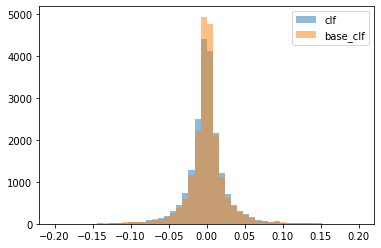

In [130]:
plt.hist(clf.predict(test_X) - test_y, bins=np.linspace(-.2, .2, 51), label='clf', alpha=0.5)
plt.hist(base_clf.predict(test_X2) - test_y, bins=np.linspace(-.2, .2, 51), label='base_clf', alpha=0.5)
plt.legend()
plt.show()

# ignore stuff below this line
dev code

In [80]:
ticker_data_matrix[price_column_to_index['close'], ticker_to_index['AAPL']]

array([  0.        ,  49.46749878,  49.86500168,  49.69499969,
         0.        ,   0.        ,  49.64500046,  48.89250183,
        49.95000076,  49.93500137,  49.47999954,   0.        ,
         0.        ,  50.38750076,  50.68249893,  51.10250092,
         0.        ,  51.05749893,   0.        ,   0.        ,
        50.00500107,  50.31000137,  50.80749893,  50.4375    ,
        50.82500076,   0.        ,   0.        ,  51.30250168,
        51.125     ,  50.83750153,  51.41500092,  50.64749908,
         0.        ,   0.        ,  51.80500031,  52.20999908,
        52.16749954,  51.75500107,  51.93500137,   0.        ,
         0.        ,  52.41999817,  52.19499969,  53.25999832,
        52.10749817,  51.00500107,   0.        ,   0.        ,
        48.33499908,  49.25      ,  49.75999832,  50.85749817,
        50.24750137,   0.        ,   0.        ,  50.11999893,
        52.24250031,  50.6875    ,  50.43500137,  51.625     ,
         0.        ,   0.        ,  52.58750153,  52.59

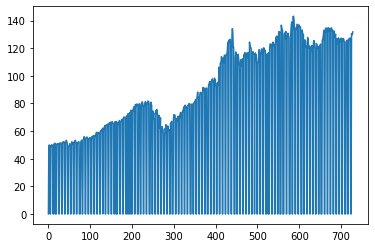

In [71]:
# check this for one ticker
ticker = 'AAPL'
ticker_to_historical_data['AAPL']
plt.plot(ticker_data_matrix[price_column_to_index['close'], ticker_to_index['AAPL']])
plt.show()


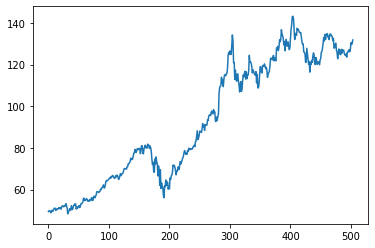

In [79]:
plt.plot(ticker_to_historical_data['AAPL']['close'])

In [60]:
6*1672* 729

7313328

In [48]:
unique_dates_array = np.array(unique_dates, dtype='datetime64').astype(np.float)

In [53]:
Counter(np.diff(unique_dates))

Counter({Timedelta('1 days 00:00:00'): 726, Timedelta('2 days 00:00:00'): 2})

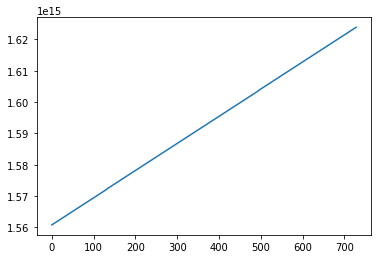

In [50]:
plt.plot(list(range(len(unique_dates_array))), unique_dates_array)
plt.show()

In [26]:
%%time

# build the features matrix
feature_matrix = []
label_matrix = []

# super slow but I don't care for toy data
# returns the ratio of the two prices
def find_stock_price(ticker, date, days_future):
    historical_ticker_data = ticker_to_historical_data[ticker]
    current_stock_data = historical_ticker_data[historical_ticker_data['date'] >= date]
    future_stock_data = historical_ticker_data[historical_ticker_data['date'] >= date + datetime.timedelta(days=days_future)]
    if len(future_stock_data) == 0:
        return None
    
    current_price = current_stock_data.iloc[0]['close']
    future_price = future_stock_data.iloc[0]['close']
    return np.log(future_price / current_price)
    
    
# TODO: look up tensorflow/keras one-hot encoding scheme
transaction_types = set(transactions_with_stock_info['type'])
transaction_types_to_index = {transaction_type: i for i, transaction_type in enumerate(sorted(transaction_types))}
def get_one_hot_transaction_variable(transaction_type):
    feature_vector = [0 for i in range(len(transaction_types_to_index))]
    # Katrina: transaction_type or transaction_types in the line below?
    feature_vector[transaction_types_to_index[transaction_type]] = 1
    return feature_vector

amounts = set(transactions_with_stock_info['amount'])
amounts = sorted(amounts, key=lambda x: int(x.split('$')[1].split('-')[0].strip().replace(',', '').replace('+', '')))
amount_to_index = {amount: i for i, amount in enumerate(amounts)}
def get_one_hot_amount_variable(amount):
    feature_vector = [0 for i in range(len(amount_to_index))]
    feature_vector[amount_to_index[amount]] = 1
    return feature_vector

def get_suspicious_politician_feature(name):
    sus_or_not = None
    
    first_name = name.split(' ')[0].lower()
    last_name = name.split(' ')[-1].lower()
    
    first_last_name_suspicious = (first_name, last_name) in suspicious_politician_first_last_name_pairs
    
    last_name_suspicious = last_name in suspicious_politician_first_last_name_pairs
    # TODO, figure out how to get the last_name_suspicious feature in
    # Katrina: first attempt done
    if first_last_name_suspicious or last_name_suspicious:
        sus_or_not = True
    else:
        sus_or_not = False

    # TODO, figure out how to return the features
    # Katrina: first attempt done
    return sus_or_not

# slow but for now who cares?
for i, row in transactions_with_stock_info.iterrows():
    if i % 1000 == 0:
        print(f'processed {i} rows')
    feature_vector = []
    feature_vector.extend(get_one_hot_transaction_variable(row['type']))
    feature_vector.extend(get_one_hot_amount_variable(row['amount']))
    feature_vector.append(int(row['cap_gains_over_200_usd']))
    # TODO: figure out how to add the suspicious politician features to the data set
    # Katrina: first attempt done
    feature_vector.append(int(get_suspicious_politician_feature(row['representative'])))
    
    # Checks if any of the sus politicians are in our historical data set. Apparently none are.
    if int(get_suspicious_politician_feature(row['representative'])):
        print('Sus or not: ', int(get_suspicious_politician_feature(row['representative'])))
    
    feature_matrix.append(feature_vector)

    label_vector = []
    label_vector.append(find_stock_price(row['cleaned_ticker'], row['disclosure_date'], 7))
    label_vector.append(find_stock_price(row['cleaned_ticker'], row['transaction_date'], 7))
    label_matrix.append(label_vector)


feature_matrix = np.array(feature_matrix)

label_matrix = np.array(label_matrix)


processed 0 rows
processed 1000 rows
processed 2000 rows
processed 3000 rows
processed 4000 rows
processed 5000 rows
processed 6000 rows
processed 8000 rows
processed 9000 rows
processed 10000 rows
Wall time: 55.9 s


In [27]:
feature_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [28]:
# split the data, build the keras models
train_matrix, test_matrix, train_labels, test_labels = train_test_split(feature_matrix, label_matrix)

num_params = train_matrix.shape[1]
input_layer = keras.layers.Input(shape=(num_params,))
batch_norm = keras.layers.BatchNormalization()(input_layer)
prev_fc_layer = batch_norm
fc_layer = None
for i in range(4):
    fc_layer = keras.layers.Dense(num_params, activation='selu', name=f'fc_{i}')(prev_fc_layer)
    prev_fc_layer = fc_layer

output_layer = keras.layers.Dense(1, name=f'output')(prev_fc_layer)
    
disclosure_date_model = keras.Model(inputs=[input_layer], outputs=[output_layer], name='disclosure_model')
disclosure_date_model.compile(loss='mean_squared_error', optimizer="adam", metrics=["mean_squared_error"])

num_params = train_matrix.shape[1]
input_layer = keras.layers.Input(shape=(num_params,))
batch_norm = keras.layers.BatchNormalization()(input_layer)
prev_fc_layer = batch_norm
for i in range(4):
    fc_layer = keras.layers.Dense(num_params, activation='selu', name=f'fc_{i}')(prev_fc_layer)
    prev_fc_layer = fc_layer
    
output_layer = keras.layers.Dense(1, name=f'output')(prev_fc_layer)

transaction_date_model = keras.Model(inputs=[input_layer], outputs=[output_layer], name='transaction_model')
transaction_date_model.compile(loss='mean_squared_error', optimizer="adam", metrics=["mean_squared_error"])

In [29]:
%%time
# train the models

# have some mask for the nan values
disclosure_mask = [not np.isnan(el) for el in train_labels[:, 0]]
transaction_mask = [not np.isnan(el) for el in train_labels[:, 1]]

disclosure_date_model.fit(
    train_matrix[disclosure_mask],
    train_labels[disclosure_mask][:, 0].flatten(),
    batch_size=(1 << 6),
    epochs=200, validation_split=0.1, verbose=2)

transaction_date_model.fit(
    train_matrix[transaction_mask],
    train_labels[transaction_mask][:, 0].flatten(),
    batch_size=(1 << 6),
    epochs=200, validation_split=0.1, verbose=2)

Epoch 1/200
96/96 - 3s - loss: 0.1490 - mean_squared_error: 0.1490 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 2/200
96/96 - 0s - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 3/200
96/96 - 0s - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 4/200
96/96 - 0s - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 5/200
96/96 - 0s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 6/200
96/96 - 0s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 7/200
96/96 - 0s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 8/200
96/96 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 9/200
96/96 - 0s - loss: 0.0059 - mean_squ

Epoch 70/200
96/96 - 0s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 71/200
96/96 - 0s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 72/200
96/96 - 0s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 73/200
96/96 - 0s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 74/200
96/96 - 0s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 75/200
96/96 - 0s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 76/200
96/96 - 0s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 77/200
96/96 - 0s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 78/200
96/96 - 0s - loss: 0.0052 -

Epoch 138/200
96/96 - 0s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 139/200
96/96 - 0s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 140/200
96/96 - 0s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 141/200
96/96 - 0s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 142/200
96/96 - 0s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 143/200
96/96 - 0s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 144/200
96/96 - 0s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 145/200
96/96 - 0s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 146/200
96/96 - 0s - loss:

Epoch 7/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 8/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 9/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 10/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 11/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 12/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 13/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 14/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 15/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 16/200
96/96 - 0s - loss:

Epoch 83/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 84/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 85/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 86/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 87/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 88/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 89/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 90/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 91/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 92/200
96/96 - 0s - lo

Epoch 159/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 160/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 161/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 162/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 163/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 164/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 165/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 166/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 167/200
96/96 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 168/200
96/96

In [30]:
# use the test set to get some idea of the error distribution
test_disclosure_mask = [not np.isnan(el) for el in test_labels[:, 0]]
test_transaction_mask = [not np.isnan(el) for el in test_labels[:, 1]]

test_disclosure_scores = disclosure_date_model.predict(test_matrix[test_disclosure_mask]).flatten()
test_transaction_scores = disclosure_date_model.predict(test_matrix[test_transaction_mask]).flatten()

test_disclosure_labels = test_labels[test_disclosure_mask, 0]
test_transaction_labels = test_labels[test_disclosure_mask, 1]

test_disclosure_errors = test_disclosure_scores - test_disclosure_labels
test_transaction_errors = test_transaction_scores - test_transaction_labels


In [31]:
disclosure_base_error = np.var(test_disclosure_labels)
disclosure_model_error = np.sum(test_disclosure_errors ** 2) / np.shape(test_disclosure_errors)[0]
# disclosure_model_error = np.var(test_disclosure_errors)

print('disclosure model')
print(np.mean(test_disclosure_labels))
print(
    disclosure_base_error,
    disclosure_model_error,
    disclosure_model_error / disclosure_base_error)

transaction_base_error = np.var(test_transaction_labels)
transaction_model_error = np.sum(test_transaction_errors ** 2) / np.shape(test_transaction_errors)[0]
# transaction_model_error = np.var(test_transaction_errors)

print('transaction model')
print(np.mean(test_transaction_labels))
print(
    transaction_base_error,
    transaction_model_error,
    transaction_model_error / transaction_base_error)


disclosure model
0.002173685575073984
0.005422953584324592 0.005540981173946373 1.0217644476919272
transaction model
0.0038966340705822505
0.00826707655673026 0.008379789093346662 1.0136339050259118
